# Capstone Project - BJB - Part 2
### Find the Sweet Spot for your Burger Place in Berlin -- Data Wrangling and Analysis

In [1]:
#import necessities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import folium
from pandas.io.json import json_normalize
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.cluster import KMeans 

### load data

In [2]:
#load previously stored data
df_ct = pd.read_csv('plz_einwohner_berlin.csv')#citizens
df_bj = pd.read_csv('cpstn_bj.csv')
df_of = pd.read_csv('cpstn_of.csv')
df_ht = pd.read_csv('cpstn_ht.csv')
berlin_geo = r'plz_5-stellig_berlin.geojson' # geojson file for plotting

### wrangl data
> We join the different data frames based on their zip code entries

In [3]:
df_bj_gr = df_bj.groupby('zip').count()
df_bj_gr.rename(columns={'name':'bj_count'},inplace=True)
df_bj_gr.drop(columns=['lat','lon','id'],inplace=True)

df_of_gr = df_of.groupby('zip').count()
df_of_gr.rename(columns={'name':'of_count'},inplace=True)
df_of_gr.drop(columns=['lat','lon','id'],inplace=True)

df_ht_gr = df_ht.groupby('zip').count()
df_ht_gr.rename(columns={'name':'ht_count'},inplace=True)
df_ht_gr.drop(columns=['lat','lon','id'],inplace=True)

df_ct = df_ct.rename(columns={'einwohner':'ct_count','plz':'zip'}).set_index('zip')

df_full = df_ct.join(df_bj_gr).join(df_of_gr).join(df_ht_gr).reset_index()# join data frames
df_full.fillna(0, inplace=True)

> Lets have a first look at the data frame that we will work with

In [4]:
# categories are zip, citizen count, burger joint count, office count, hotel count - all per zip code area
df_full.head()

zip  ct_count  bj_count  of_count  ht_count
0  10115     20313       2.0      12.0       5.0
1  10117     12217       5.0      14.0      21.0
2  10119     16363       7.0      15.0      11.0
3  10178     12167       7.0      15.0      14.0
4  10179     18664       2.0      11.0      12.0

In [5]:
df_full.describe()

zip      ct_count    bj_count    of_count    ht_count
count    191.000000    191.000000  191.000000  191.000000  191.000000
mean   12217.282723  17305.502618    1.308901    8.706806    3.680628
std     1243.486987   6295.166357    1.920492    7.724050    3.752556
min    10115.000000    139.000000    0.000000    0.000000    0.000000
25%    10806.000000  13414.500000    0.000000    3.000000    1.000000
50%    12353.000000  16865.000000    1.000000    7.000000    3.000000
75%    13350.000000  21565.500000    2.000000   12.000000    5.000000
max    14199.000000  35360.000000    9.000000   59.000000   21.000000

### Data visualization

 > First we visualize the data frames as maps for Berlin to get a better overview. 

In [6]:
# create a plain Berlin map
map_berlin = folium.Map(location=[52.52437, 13.41053], zoom_start=10, tiles='Mapbox Bright')

#bring data frame in plottable form
df_plot = df_ct
df_plot.reset_index(inplace=True)
df_plot = df_plot.astype({'zip':str})

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_plot['ct_count'].min(),
                              df_plot['ct_count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# generate choropleth map 
map_berlin.choropleth(
    geo_data=berlin_geo,
    data=df_plot,
    columns=['zip', 'ct_count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    threshold_scale = threshold_scale,
    legend_name='Number of Citizens',
)
# display map
map_berlin

In [7]:
# create map of Berlin 
map_berlin = folium.Map(location=[52.52437, 13.41053], zoom_start=10)

# add markers to map - blue is burger places
for lat, lng, name in zip(df_bj['lat'], df_bj['lon'], df_bj['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],radius=1, popup=label, color='blue', line_opacity=0.5, parse_html=False).add_to(map_berlin) 
# add markers to map - green is hotels
for lat, lng, name in zip(df_ht['lat'], df_ht['lon'], df_ht['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],radius=1, popup=label, color='green', line_opacity=0.5, parse_html=False).add_to(map_berlin) 
# add markers to map - red are office locations
for lat, lng, name in zip(df_of['lat'], df_of['lon'], df_of['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],radius=1, popup=label, color='red', line_opacity=0.5, parse_html=False).add_to(map_berlin) 
# add a fixed legend 
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 310px; left: 50px; width: 90px; height: 60px; 
                            border:2px solid grey; z-index:9999; font-size:10px;
                            ">&nbsp; Categories<br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:blue"></i> &nbsp; Burger Joints<br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i> &nbsp; Hotels  <br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i> &nbsp; Offices 
                </div>
                ''' 

map_berlin.get_root().html.add_child(folium.Element(legend_html))

map_berlin

> Let us check if there are obvious dependencies between the parameters.

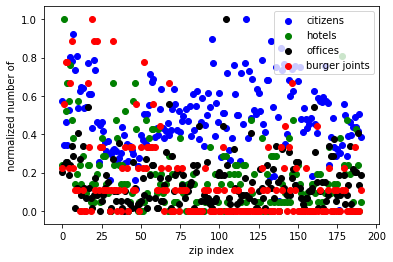

In [8]:
# plot citizen count, burger joint count, office count, hotel count against zip code
plt.scatter(df_full.index, df_full['ct_count'].values/df_full['ct_count'].max(), color = 'b')
plt.scatter(df_full.index, df_full['ht_count'].values/df_full['ht_count'].max(), color = 'g')
plt.scatter(df_full.index, df_full['of_count'].values/df_full['of_count'].max(), color = 'k')
plt.scatter(df_full.index, df_full['bj_count'].values/df_full['bj_count'].max(), color = 'r')
plt.xlabel("zip index")
plt.ylabel("normalized number of")
plt.legend(['citizens','hotels','offices','burger joints'])
plt.show()

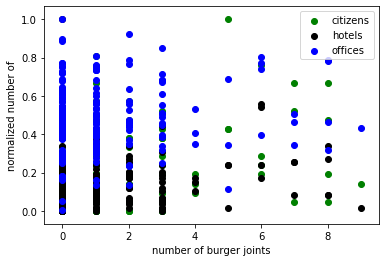

In [9]:
# plot citizen count, office count, hotel count against burger joints
plt.scatter(df_full.bj_count, df_full['ht_count'].values/df_full['ht_count'].max(), color = 'g')
plt.scatter(df_full.bj_count, df_full['of_count'].values/df_full['of_count'].max(), color = 'k')
plt.scatter(df_full.bj_count, df_full['ct_count'].values/df_full['ct_count'].max(), color = 'b')
plt.xlabel("number of burger joints")
plt.ylabel("normalized number of")
plt.legend(['citizens','hotels','offices'])
plt.show()

>There is no obvious trend or segmentation in the data. This suggest a Kmeans type of clustering/segmenstation ansatz. 

### Data Analysis using Kmeans clustering

> The data needs to be normalized to account for the different ranges of data in each category. 
> After the normalization we can apply a customized weighting. So e.g. we decide here to weight down the number of citizens, and weight up the inverse number of  existing burger places. 

In [10]:
#prepare kmeans clustering
df_full = df_full.set_index('zip')
X = df_full.values
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
#change weighting
Clus_dataSet[:,0] = Clus_dataSet[:,0]*0.5   # citizens only weigh half
Clus_dataSet[:,1] = Clus_dataSet[:,1]*2   # exisiting burger joints weigh twice

In [11]:
# compute kmeans
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 500, random_state=17)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
df_full["c_km"] = labels

> We explore the results of the clutering 

In [12]:
df_full.head(4)

ct_count  bj_count  of_count  ht_count  c_km
zip                                                
10115     20313       2.0      12.0       5.0     1
10117     12217       5.0      14.0      21.0     2
10119     16363       7.0      15.0      11.0     2
10178     12167       7.0      15.0      14.0     2

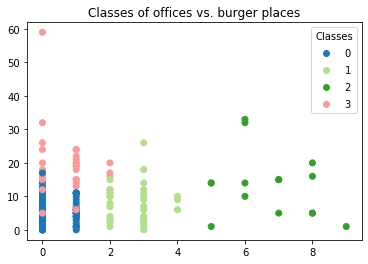

In [13]:
cmap = plt.cm.get_cmap('Paired',12)
newcmap = ListedColormap(cmap([1,2,3,4]))

fig, ax = plt.subplots()
scatter = ax.scatter(df_full.bj_count,df_full.of_count, c = df_full.c_km, cmap = newcmap)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
ax.set_title('Classes of offices vs. burger places');

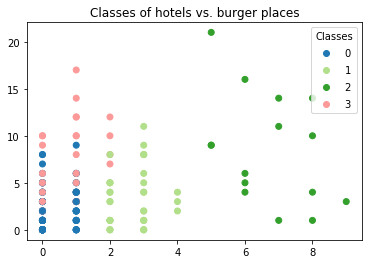

In [14]:
fig, ax = plt.subplots()
scatter = ax.scatter(df_full.bj_count,df_full.ht_count, c = df_full.c_km, cmap =newcmap)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
ax.set_title('Classes of hotels vs. burger places');

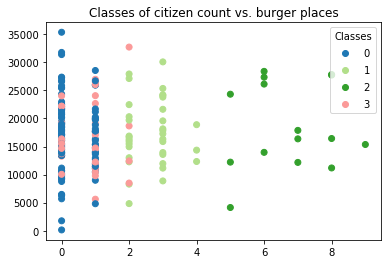

In [15]:
fig, ax = plt.subplots()
scatter = ax.scatter(df_full.bj_count,df_full.ct_count, c = df_full.c_km, cmap =newcmap )
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title('Classes of citizen count vs. burger places');

> Now let us look at the entire results plotted onto a Berlin map.

In [16]:
# bring data into plottable form
df_plot = df_full.reset_index()
df_plot = df_plot.astype({'zip':str}) 
df_plot = df_plot.astype({'c_km':int})
# create a plain Berlin map
berlin_map = folium.Map(location=[52.52437, 13.41053], zoom_start=10, tiles='Mapbox Bright')

# create threshold
threshold_scale = np.linspace(0,
                              df_plot['c_km'].max()+1,
                              df_plot['c_km'].max()+2, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list

# generate choropleth map 
berlin_map.choropleth(
    geo_data=berlin_geo,
    data=df_plot,
    columns=['zip', 'c_km'],
    key_on='feature.properties.name',
    fill_color='Paired', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    threshold_scale = threshold_scale
)
# display map
berlin_map

In [17]:
df_mean = df_full.groupby('c_km').mean()
df_mean

ct_count  bj_count   of_count  ht_count
c_km                                             
0     17030.037736  0.301887   5.415094  2.103774
1     17464.828571  2.657143   7.542857  3.428571
2     18760.733333  6.733333  13.333333  8.533333
3     17356.771429  0.685714  17.857143  6.628571

In [18]:
df_mean = df_full.groupby('c_km').mean()
colnames = df_mean.columns
X = df_mean.values
X = np.nan_to_num(X)
X_scaled = MaxAbsScaler().fit_transform(X)
df_mean = pd.DataFrame(X_scaled)
df_mean.columns = colnames
df_mean

ct_count  bj_count  of_count  ht_count
0  0.907749  0.044835  0.303245  0.246536
1  0.930925  0.394625  0.422400  0.401786
2  1.000000  1.000000  0.746667  1.000000
3  0.925165  0.101839  1.000000  0.776786

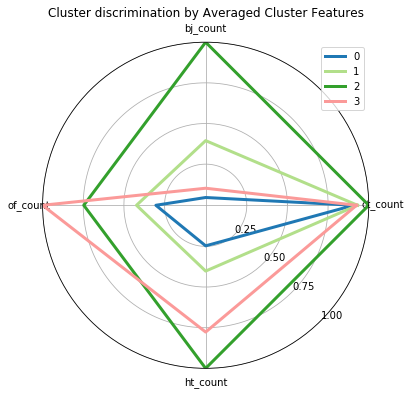

In [19]:
# plot category circle
cmap = plt.cm.get_cmap('Paired')
rgba = cmap(list(np.linspace(0,1,12)))

theta = 2 * np.pi * np.array([0,0.25,0.5,0.75])
theta = np.append(theta,theta[0])

plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='polar')
for rdx in range(df_mean.shape[0]) :
    r = df_mean.values[rdx,:]
    r = np.append(r,r[0])
    ax.plot(theta, r,linewidth=3, color = rgba[rdx+1])

ax.set_rmax(1)
ax.set_rticks([0.25,0.5,0.75, 1])  # Less radial ticks
ax.set_xticks(2 * np.pi * np.array([0,0.25,0.5,0.75]))

ax.set_xticklabels(list(df_mean.columns))

ax.set_rlabel_position(-45)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Cluster discrimination by Averaged Cluster Features", va='bottom')

ax.legend(list(df_mean.index))
plt.show()

> The figure shows that the preferred cluster is cluster 3, where few burger places would mean less competition, high office counts, hotel counts, and citizen counts would mean many possible customers. <br>